## Imports

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Hyper Parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 16
learning_rate = 0.001

## Load MNIST

In [4]:
# MNIST Dataset 
train_dataset = dsets.MNIST(
    root='./data', 
    train=True, 
    transform=transforms.ToTensor(),  
    download=True,
)

test_dataset = dsets.MNIST(
    root='./data', 
    train=False, 
    transform=transforms.ToTensor(),
)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

/home/derek/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


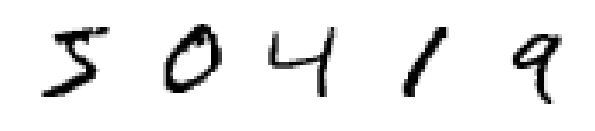

In [5]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = transforms.Compose([transforms.ToPILImage(), transforms.Scale(28)])(train_dataset[index][0])
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [6]:
train_dataset.train_data.shape

torch.Size([60000, 28, 28])

In [7]:
train_dataset.train_labels[:n_samples]


 5
 0
 4
 1
 9
[torch.LongTensor of size 5]

## Primary Capsules

In [8]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

In [9]:
feature_size = caps1_n_maps * caps1_n_dims
layer = nn.Sequential(
    nn.Conv2d(1, feature_size, kernel_size=9),
    nn.BatchNorm2d(feature_size),
    nn.ReLU(),
    nn.Conv2d(feature_size, feature_size, kernel_size=9, stride=2),
    nn.BatchNorm2d(feature_size),
    nn.ReLU(),
)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1, 
                                           shuffle=True)

In [11]:
# When iteration starts, queue and thread start to load dataset from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

In [12]:
images


(0 ,0 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2510  0.7490
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  1.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.2510  1.0000  1.0000
  0.0000  0.0000 

In [13]:
example_image = Variable(images)

In [14]:
x = layer(example_image)

In [15]:
x = x.view(-1, caps1_n_caps, caps1_n_dims)
x

Variable containing:
( 0  ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.1686  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0853  0.3195
  0.0000  0.7998  0.0000  ...   0.0000  0.1497  0.0000
           ...             ⋱             ...          
  0.0978  0.0000  0.0206  ...   0.0000  0.0000  0.0705
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 1x1152x8]

In [16]:
def squash(tensor, dim=-1, epsilon=1e-7):
    squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
    safe_norm = torch.sqrt(squared_norm + epsilon)
    scale = squared_norm / (1 + squared_norm)
    return scale * tensor / safe_norm

In [17]:
x = squash(x)
x

Variable containing:
( 0  ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0360  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0254  0.0953
  0.0000  0.3790  0.0000  ...   0.0000  0.0709  0.0000
           ...             ⋱             ...          
  0.0408  0.0000  0.0086  ...   0.0000  0.0000  0.0295
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 1x1152x8]

## Digit Capsules

## Compute the Predicted Output Vectors

In [8]:
caps2_n_caps = 10
caps2_n_dims = 16

In [19]:
init_sigma = 0.01
W_init = torch.Tensor(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims)
W_init = Variable(W_init.normal_(std=init_sigma))
print(W_init.size())

torch.Size([1, 1152, 10, 16, 8])


In [20]:
x = x[:,:,None,:,None].repeat(1,1,10,1,1)
print(x.size())

torch.Size([1, 1152, 10, 8, 1])


In [21]:
caps2_predicted = W_init @ x
print(caps2_predicted.size())

torch.Size([1, 1152, 10, 16, 1])


## Routing by agreement

In [22]:
raw_weights = Variable(torch.zeros(1, caps1_n_caps, caps2_n_caps, 1, 1))
print(raw_weights.shape)

torch.Size([1, 1152, 10, 1, 1])


### Round 1

In [23]:
import torch.nn.functional as F

In [24]:
routing_weights = F.softmax(raw_weights,dim=2)
print(routing_weights.shape)

torch.Size([1, 1152, 10, 1, 1])


In [25]:
weighted_predictions = routing_weights * caps2_predicted
print(weighted_predictions.shape)

torch.Size([1, 1152, 10, 16, 1])


In [26]:
weighted_sum = weighted_predictions.sum(dim=1, keepdim=True)
print(weighted_sum.shape)

torch.Size([1, 1, 10, 16, 1])


In [27]:
caps2_output_round_1 = squash(weighted_sum, dim=-2)

### Round 2

In [28]:
caps2_output_round_1_tiled = caps2_output_round_1.repeat(1, caps1_n_caps, 1, 1, 1)
print(caps2_output_round_1_tiled.shape) 

torch.Size([1, 1152, 10, 16, 1])


In [29]:
agreement = caps2_predicted.transpose(-1, -2) @ caps2_output_round_1_tiled
print(agreement.shape)

torch.Size([1, 1152, 10, 1, 1])


In [30]:
raw_weights_round_2 = raw_weights + agreement
print(raw_weights_round_2.shape)

torch.Size([1, 1152, 10, 1, 1])


In [31]:
routing_weights_round_2 = F.softmax(raw_weights_round_2,dim=2)
print(routing_weights_round_2.shape)

torch.Size([1, 1152, 10, 1, 1])


In [32]:
weighted_predictions_round_2 = routing_weights_round_2 * caps2_predicted
print(routing_weights_round_2.shape)

torch.Size([1, 1152, 10, 1, 1])


In [33]:
weighted_sum_round_2 = weighted_predictions_round_2.sum(dim=1, keepdim=True)
print(weighted_sum_round_2.shape)

torch.Size([1, 1, 10, 16, 1])


In [34]:
caps2_output_round_2 = squash(weighted_sum_round_2, dim=-2)

In [35]:
caps2_output = caps2_output_round_2

## Estimated Class Probabilities (Length)

In [36]:
def safe_norm(tensor, dim=-1, epsilon=1e-7, keepdim=False):
    squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
    return torch.sqrt(squared_norm + epsilon)

In [37]:
y_proba = safe_norm(caps2_output, dim=-2)
print(y_proba.shape)

torch.Size([1, 1, 10, 1, 1])


In [38]:
y_proba_argmax = torch.max(y_proba, dim=2)[1]
y_proba_argmax.shape

torch.Size([1, 1, 1, 1])

In [39]:
y_pred = torch.squeeze(y_proba_argmax)
y_pred.shape

torch.Size([1])

## Labels

In [40]:
y = labels.float()
y


 4
[torch.FloatTensor of size 1]

## Margin loss

In [41]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [42]:
T = Variable(torch.eye(num_classes).index_select(dim=0, index=labels))
# T = torch.Tensor(batch_size, num_classes).scatter_(1, torch.LongTensor(labels)[:,None],1)

In [43]:
caps2_output

Variable containing:
(0 ,0 ,0 ,.,.) = 
1.00000e-03 *
  -0.2325
  -0.3222
   2.9180
  -0.1554
   0.9319
  -0.6061
  -2.4007
   0.8849
  -0.5356
   0.5044
  -2.3594
   3.0347
   2.1489
  -0.4929
   1.9136
   0.6000

(0 ,0 ,1 ,.,.) = 
1.00000e-03 *
  -1.2087
   1.8070
   0.8415
  -0.3420
  -0.4328
  -1.6493
   2.3560
   0.9145
  -0.3877
   0.9408
   0.4515
  -1.0223
  -1.0542
   0.8221
  -0.4048
  -0.7833

(0 ,0 ,2 ,.,.) = 
1.00000e-03 *
   1.0503
   1.3430
   0.5619
  -1.2391
   0.8155
  -0.5785
  -0.6234
   0.6751
  -0.5354
  -0.8307
   0.4379
   0.2040
  -0.4175
  -0.1044
  -0.1206
  -0.7733

(0 ,0 ,3 ,.,.) = 
1.00000e-03 *
   1.2199
  -0.7606
   0.8090
  -0.1018
  -0.9332
   0.4343
   0.9381
   0.5927
  -0.4354
   0.8690
   0.1962
   0.7631
  -0.4178
   1.1347
  -0.6458
  -2.1344

(0 ,0 ,4 ,.,.) = 
1.00000e-03 *
   1.7153
   1.2189
   0.1188
  -0.0064
   1.5830
  -0.0556
  -0.8988
  -0.4481
   0.1761
  -0.8921
   0.2861
   1.2341
   0.3663
  -0.0960
   0.1012
   0.0134

(0 ,0 ,5 ,.,.)

In [44]:
caps2_output_norm = safe_norm(caps2_output, dim=-2, keepdim=True)
caps2_output_norm.shape

torch.Size([1, 1, 10, 1, 1])

In [45]:
#         reconstruction_loss = self.reconstruction_loss(reconstructions, images)

#         return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)
present_error_raw = F.relu(m_plus - caps2_output_norm, inplace=True) ** 2
present_error = present_error_raw.view(-1, 10)
present_error

Variable containing:
 0.7985  0.8020  0.8047  0.8035  0.8041  0.8058  0.8003  0.7945  0.7991  0.8044
[torch.FloatTensor of size 1x10]

In [46]:
absent_error_raw = F.relu(caps2_output_norm - m_minus, inplace=True) ** 2
absent_error = absent_error_raw.view(-1, 10)
absent_error

Variable containing:
    0     0     0     0     0     0     0     0     0     0
[torch.FloatTensor of size 1x10]

In [47]:
L = T * present_error + lambda_ * (1. - T) * absent_error
L

Variable containing:
 0.0000  0.0000  0.0000  0.0000  0.8041  0.0000  0.0000  0.0000  0.0000  0.0000
[torch.FloatTensor of size 1x10]

In [49]:
margin_loss = torch.mean(torch.sum(L))
margin_loss 

Variable containing:
 0.8041
[torch.FloatTensor of size 1]

## Reconstruction

### Mask

In [50]:
caps2_output #.index_select(dim=2, index=Variable(labels))

Variable containing:
(0 ,0 ,0 ,.,.) = 
1.00000e-03 *
  -0.2325
  -0.3222
   2.9180
  -0.1554
   0.9319
  -0.6061
  -2.4007
   0.8849
  -0.5356
   0.5044
  -2.3594
   3.0347
   2.1489
  -0.4929
   1.9136
   0.6000

(0 ,0 ,1 ,.,.) = 
1.00000e-03 *
  -1.2087
   1.8070
   0.8415
  -0.3420
  -0.4328
  -1.6493
   2.3560
   0.9145
  -0.3877
   0.9408
   0.4515
  -1.0223
  -1.0542
   0.8221
  -0.4048
  -0.7833

(0 ,0 ,2 ,.,.) = 
1.00000e-03 *
   1.0503
   1.3430
   0.5619
  -1.2391
   0.8155
  -0.5785
  -0.6234
   0.6751
  -0.5354
  -0.8307
   0.4379
   0.2040
  -0.4175
  -0.1044
  -0.1206
  -0.7733

(0 ,0 ,3 ,.,.) = 
1.00000e-03 *
   1.2199
  -0.7606
   0.8090
  -0.1018
  -0.9332
   0.4343
   0.9381
   0.5927
  -0.4354
   0.8690
   0.1962
   0.7631
  -0.4178
   1.1347
  -0.6458
  -2.1344

(0 ,0 ,4 ,.,.) = 
1.00000e-03 *
   1.7153
   1.2189
   0.1188
  -0.0064
   1.5830
  -0.0556
  -0.8988
  -0.4481
   0.1761
  -0.8921
   0.2861
   1.2341
   0.3663
  -0.0960
   0.1012
   0.0134

(0 ,0 ,5 ,.,.)

In [51]:
y_pred_one_hot = Variable(torch.eye(num_classes).index_select(dim=0, index=y_pred.data))
y_pred_one_hot

Variable containing:
    0     0     0     0     0     0     0     1     0     0
[torch.FloatTensor of size 1x10]

In [52]:
mask_with_labels = False # default to use predictions

In [53]:
reconstruction_mask = T if mask_with_labels else y_pred_one_hot
# T.view(-1, 1, caps2_n_caps, 1, 1) * caps2_output
reconstruction_mask_reshaped = reconstruction_mask.view(-1, 1, caps2_n_caps, 1, 1)
reconstruction_mask_reshaped

Variable containing:
(0 ,0 ,0 ,.,.) = 
  0

(0 ,0 ,1 ,.,.) = 
  0

(0 ,0 ,2 ,.,.) = 
  0

(0 ,0 ,3 ,.,.) = 
  0

(0 ,0 ,4 ,.,.) = 
  0

(0 ,0 ,5 ,.,.) = 
  0

(0 ,0 ,6 ,.,.) = 
  0

(0 ,0 ,7 ,.,.) = 
  1

(0 ,0 ,8 ,.,.) = 
  0

(0 ,0 ,9 ,.,.) = 
  0
[torch.FloatTensor of size 1x1x10x1x1]

In [54]:
caps2_output_masked = reconstruction_mask_reshaped * caps2_output
caps2_output_masked

Variable containing:
(0 ,0 ,0 ,.,.) = 
1.00000e-03 *
  -0.0000
  -0.0000
   0.0000
  -0.0000
   0.0000
  -0.0000
  -0.0000
   0.0000
  -0.0000
   0.0000
  -0.0000
   0.0000
   0.0000
  -0.0000
   0.0000
   0.0000

(0 ,0 ,1 ,.,.) = 
1.00000e-03 *
  -0.0000
   0.0000
   0.0000
  -0.0000
  -0.0000
  -0.0000
   0.0000
   0.0000
  -0.0000
   0.0000
   0.0000
  -0.0000
  -0.0000
   0.0000
  -0.0000
  -0.0000

(0 ,0 ,2 ,.,.) = 
1.00000e-03 *
   0.0000
   0.0000
   0.0000
  -0.0000
   0.0000
  -0.0000
  -0.0000
   0.0000
  -0.0000
  -0.0000
   0.0000
   0.0000
  -0.0000
  -0.0000
  -0.0000
  -0.0000

(0 ,0 ,3 ,.,.) = 
1.00000e-03 *
   0.0000
  -0.0000
   0.0000
  -0.0000
  -0.0000
   0.0000
   0.0000
   0.0000
  -0.0000
   0.0000
   0.0000
   0.0000
  -0.0000
   0.0000
  -0.0000
  -0.0000

(0 ,0 ,4 ,.,.) = 
1.00000e-03 *
   0.0000
   0.0000
   0.0000
  -0.0000
   0.0000
  -0.0000
  -0.0000
  -0.0000
   0.0000
  -0.0000
   0.0000
   0.0000
   0.0000
  -0.0000
   0.0000
   0.0000

(0 ,0 ,5 ,.,.)

In [55]:
decoder_input = caps2_output_masked.view(-1, caps2_n_caps * caps2_n_dims)
decoder_input

Variable containing:

Columns 0 to 9 
1.00000e-03 *
 -0.0000 -0.0000  0.0000 -0.0000  0.0000 -0.0000 -0.0000  0.0000 -0.0000  0.0000

Columns 10 to 19 
1.00000e-03 *
 -0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000 -0.0000

Columns 20 to 29 
1.00000e-03 *
 -0.0000 -0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000 -0.0000 -0.0000  0.0000

Columns 30 to 39 
1.00000e-03 *
 -0.0000 -0.0000  0.0000  0.0000  0.0000 -0.0000  0.0000 -0.0000 -0.0000  0.0000

Columns 40 to 49 
1.00000e-03 *
 -0.0000 -0.0000  0.0000  0.0000 -0.0000 -0.0000 -0.0000 -0.0000  0.0000 -0.0000

Columns 50 to 59 
1.00000e-03 *
  0.0000 -0.0000 -0.0000  0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000  0.0000

Columns 60 to 69 
1.00000e-03 *
 -0.0000  0.0000 -0.0000 -0.0000  0.0000  0.0000  0.0000 -0.0000  0.0000 -0.0000

Columns 70 to 79 
1.00000e-03 *
 -0.0000 -0.0000  0.0000 -0.0000  0.0000  0.0000  0.0000 -0.0000  0.0000  0.0000

Columns 80 to 89 
1.00000e-03 *
  0.0000 -0.0000 -0.0000  0.0000  0.

## Decoder

In [56]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [57]:
decoder_output = nn.Sequential(
    nn.Linear(caps2_n_caps * caps2_n_dims, n_hidden1),
    nn.ReLU(inplace=True),
    nn.Linear(n_hidden1, n_hidden2),
    nn.ReLU(inplace=True),
    nn.Linear(n_hidden2, n_output),
    nn.Sigmoid(),
)(decoder_input)
decoder_output

Variable containing:

Columns 0 to 9 
 0.4882  0.5021  0.4890  0.5001  0.4970  0.5050  0.5035  0.5010  0.4928  0.5022

Columns 10 to 19 
 0.5020  0.4920  0.5079  0.4925  0.4970  0.4975  0.4926  0.4933  0.5067  0.5028

Columns 20 to 29 
 0.4977  0.4976  0.5062  0.4972  0.5056  0.4944  0.5055  0.5046  0.4973  0.4979

Columns 30 to 39 
 0.5101  0.5045  0.4958  0.4956  0.4949  0.5034  0.5019  0.5022  0.4927  0.4938

Columns 40 to 49 
 0.4999  0.5026  0.5050  0.5027  0.5017  0.4962  0.5102  0.5055  0.5013  0.5049

Columns 50 to 59 
 0.5051  0.5044  0.4978  0.4992  0.4956  0.5029  0.4933  0.4964  0.5022  0.4954

Columns 60 to 69 
 0.5039  0.4962  0.5075  0.5060  0.4983  0.5030  0.4974  0.4896  0.5034  0.5104

Columns 70 to 79 
 0.4937  0.4886  0.4894  0.5010  0.5126  0.5010  0.4903  0.5020  0.5044  0.5048

Columns 80 to 89 
 0.4966  0.4987  0.4932  0.5082  0.4926  0.5087  0.4953  0.4985  0.5015  0.4972

Columns 90 to 99 
 0.4962  0.4933  0.4992  0.4942  0.5057  0.4897  0.5013  0.4967  0.4954

/home/derek/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


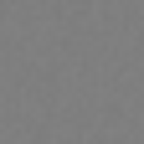

In [58]:
from matplotlib import pyplot as plt
transforms.Compose([transforms.ToPILImage(), transforms.Scale(144)])(decoder_output.data.view(-1, 28, 28))

## Reconstruction Loss

In [59]:
reconstruction_loss = nn.MSELoss(size_average=False)(decoder_output, example_image.view(batch_size,-1))
reconstruction_loss

Variable containing:
 183.4392
[torch.FloatTensor of size 1]

## Final Loss

In [60]:
alpha = 0.0005

In [61]:
loss = margin_loss + alpha * reconstruction_loss
loss

Variable containing:
 0.8959
[torch.FloatTensor of size 1]

## Final Touches

## Accuracy

In [62]:
correct = y == y_pred.data.float()
torch.mean(correct.float())

0.0

## Training Operations

In [63]:
from torch.optim import Adam

In [64]:
# optimizer = Adam()
loss.backward()
loss

Variable containing:
 0.8959
[torch.FloatTensor of size 1]

## Training

In [17]:
class PrimaryCapsuleLayer(nn.Module):
    
    def __init__(self, caps1_n_maps=32, caps1_n_dims=8):
        super(PrimaryCapsuleLayer, self).__init__()
        self.caps1_n_maps = caps1_n_maps
        self.caps1_n_dims = caps1_n_dims
        self.caps1_n_caps = caps1_n_maps * 6 * 6 # 1152 primary capsules
        
        feature_size = caps1_n_maps * caps1_n_dims
        self.layer = nn.Sequential(
            nn.Conv2d(1, feature_size, kernel_size=9),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(),
            nn.Conv2d(feature_size, feature_size, kernel_size=9, stride=2),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(),
        )
        
    def squash(self, tensor, dim=-1, epsilon=1e-7):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        safe_norm = torch.sqrt(squared_norm + epsilon)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / safe_norm
    
    def forward(self, x):
        out = self.layer(x)
        out = out.view(-1, self.caps1_n_caps, self.caps1_n_dims)
        out = self.squash(out)
        return out
    
class DigitCapsuleLayer(nn.Module):
    
    init_sigma = 0.01
    
    def __init__(self, caps1_n_caps=1152, caps1_n_dims=8, caps2_n_caps=10, caps2_n_dims=16):
        super(DigitCapsuleLayer, self).__init__()
        self.caps2_n_caps = caps2_n_caps
        self.caps1_n_caps = caps1_n_caps
        W_init = torch.Tensor(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims)
        W_init.normal_(std=self.init_sigma)
        self.w_init = nn.Parameter(W_init).cuda()
        
    def squash(self, tensor, dim=-1, epsilon=1e-7):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        safe_norm = torch.sqrt(squared_norm + epsilon)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / safe_norm
        
    def forward(self, x):
        # round 1
        x_ = x[:,:,None,:,None].repeat(1,1,10,1,1)
        caps2_predicted = self.w_init @ x_
        raw_weights = Variable(torch.zeros(1, self.caps1_n_caps, self.caps2_n_caps, 1, 1)).cuda()
        routing_weights = F.softmax(raw_weights,dim=2)
        weighted_predictions = routing_weights * caps2_predicted
        weighted_sum = weighted_predictions.sum(dim=1, keepdim=True)
        caps2_output_round_1 = self.squash(weighted_sum, dim=-2)
        
        # round 2
        caps2_output_round_1_tiled = caps2_output_round_1.repeat(1, self.caps1_n_caps, 1, 1, 1)
        agreement = caps2_predicted.transpose(-1, -2) @ caps2_output_round_1_tiled
        raw_weights_round_2 = raw_weights + agreement
        routing_weights_round_2 = F.softmax(raw_weights_round_2,dim=2)
        weighted_predictions_round_2 = routing_weights_round_2 * caps2_predicted
        weighted_sum_round_2 = weighted_predictions_round_2.sum(dim=1, keepdim=True)
        caps2_output_round_2 = self.squash(weighted_sum_round_2, dim=-2)
        caps2_output = caps2_output_round_2
        return caps2_output

In [21]:
class CapsuleNet(nn.Module):
    def __init__(self, caps2_n_caps=10, caps2_n_dims=16):
        super(CapsuleNet, self).__init__()
        self.primary_capsules = PrimaryCapsuleLayer()
        self.digit_capsules = DigitCapsuleLayer()
        self.caps2_n_caps = caps2_n_caps
        self.caps2_n_dims = caps2_n_dims
        self.decoder = nn.Sequential(
            nn.Linear(16 * num_classes, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        out = self.primary_capsules(x)
        caps2_output = self.digit_capsules(out)
        
        def safe_norm(tensor, dim=-1, epsilon=1e-7, keepdim=False):
            squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
            return torch.sqrt(squared_norm + epsilon)

        y_proba = safe_norm(caps2_output, dim=-2)
        y_proba_argmax = torch.max(y_proba, dim=2)[1]
        y_pred = torch.squeeze(y_proba_argmax)
        
#         m_plus = 0.9
#         m_minus = 0.1
#         lambda_ = 0.5

        T = Variable(torch.eye(num_classes).index_select(dim=0, index=labels)).cuda()
#         caps2_output_norm = safe_norm(caps2_output, dim=-2, keepdim=True)

#         present_error_raw = F.relu(m_plus - caps2_output_norm, inplace=True) ** 2
#         present_error = present_error_raw.view(-1, 10)

#         absent_error_raw = F.relu(caps2_output_norm - m_minus, inplace=True) ** 2
#         absent_error = absent_error_raw.view(-1, 10)

#         L = T * present_error + lambda_ * (1. - T) * absent_error

#         margin_loss = torch.mean(torch.sum(L))
        
        y_pred_one_hot = Variable(torch.eye(num_classes).index_select(dim=0, index=y_pred.cpu().data)).cuda()
        mask_with_labels = self.training # default to use predictions

        reconstruction_mask = T if mask_with_labels else y_pred_one_hot
        reconstruction_mask_reshaped = reconstruction_mask.view(-1, 1, self.caps2_n_caps, 1, 1)

        caps2_output_masked = reconstruction_mask_reshaped * caps2_output
        decoder_input = caps2_output_masked.view(-1, self.caps2_n_caps * self.caps2_n_dims)

        n_hidden1 = 512
        n_hidden2 = 1024
        n_output = 28 * 28

#         decoder_output = nn.Sequential(
#             nn.Linear(caps2_n_caps * caps2_n_dims, n_hidden1),
#             nn.ReLU(inplace=True),
#             nn.Linear(n_hidden1, n_hidden2),
#             nn.ReLU(inplace=True),
#             nn.Linear(n_hidden2, n_output),
#             nn.Sigmoid(),
#         )(decoder_input)
        decoder_output = self.decoder(decoder_input)

#         reconstruction_loss = self.reconstruction_loss(decoder_output, x.view(batch_size,-1))

#         alpha = 0.0005

#         loss = margin_loss + alpha * reconstruction_loss
#         return loss
        return caps2_output, y_pred, decoder_output
    
class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)
    
    def forward(self, x, labels, caps2_output, y_pred, decoder_output):
        m_plus = 0.9
        m_minus = 0.1
        lambda_ = 0.5
        
        def safe_norm(tensor, dim=-1, epsilon=1e-7, keepdim=False):
            squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
            return torch.sqrt(squared_norm + epsilon)

        T = Variable(torch.eye(num_classes).index_select(dim=0, index=labels)).cuda()
        caps2_output_norm = safe_norm(caps2_output, dim=-2, keepdim=True)

        present_error_raw = F.relu(m_plus - caps2_output_norm, inplace=True) ** 2
        present_error = present_error_raw.view(-1, 10)

        absent_error_raw = F.relu(caps2_output_norm - m_minus, inplace=True) ** 2
        absent_error = absent_error_raw.view(-1, 10)

        L = T * present_error + lambda_ * (1. - T) * absent_error

        margin_loss = torch.mean(torch.sum(L))
        
        reconstruction_loss = self.reconstruction_loss(decoder_output, x.view(batch_size,-1))

        alpha = 0.0005

        loss = margin_loss + alpha * reconstruction_loss
        return loss
    

In [22]:
from torch.optim import Adam

model = CapsuleNet()
model.cuda()
criterion = CapsuleLoss().cuda()
optimizer = Adam(model.parameters())

model.parameters

<bound method Module.parameters of CapsuleNet(
  (primary_capsules): PrimaryCapsuleLayer(
    (layer): Sequential(
      (0): Conv2d (1, 256, kernel_size=(9, 9), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU()
      (3): Conv2d (256, 256, kernel_size=(9, 9), stride=(2, 2))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU()
    )
  )
  (digit_capsules): DigitCapsuleLayer(
  )
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=1024)
    (3): ReLU(inplace)
    (4): Linear(in_features=1024, out_features=784)
    (5): Sigmoid()
  )
)>

In [48]:
data_iter = iter(train_loader)

# for _ in range(5):
#     images, labels = data_iter.next()
#     images = Variable(images).cuda()
#     labels = labels

#     # Forward + Backward + Optimize
#     optimizer.zero_grad()
#     caps2_output, y_pred, decoder_output = model(images, labels)
#     loss = CapsuleLoss()(images, labels, caps2_output, y_pred, decoder_output)
#     loss.backward()
#     optimizer.step()

In [14]:
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = labels

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        caps2_output, y_pred, decoder_output = model(images, labels)
        loss = criterion(images, labels, caps2_output, y_pred, decoder_output)
        loss.backward()
        optimizer.step()
    print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Epoch [1/5], Iter [3750/3750] Loss: 0.6020
Epoch [2/5], Iter [3750/3750] Loss: 0.3940
Epoch [3/5], Iter [3750/3750] Loss: 0.2034
Epoch [4/5], Iter [3750/3750] Loss: 0.1927
Epoch [5/5], Iter [3750/3750] Loss: 0.1587


In [49]:
images, labels = data_iter.next()
images = Variable(images).cuda()
labels = labels

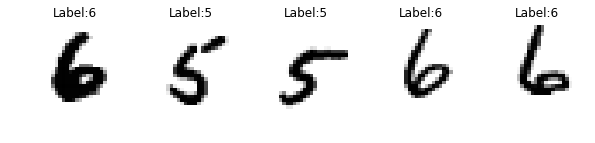

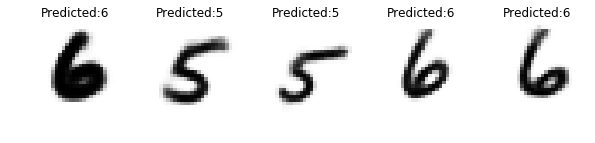

In [50]:
caps2_output, y_pred, decoder_output = model(images, labels)
reshaped_images = images.cpu().data.numpy().reshape(-1, 28, 28)
reconstructions = decoder_output.view(-1,28,28).cpu().data.numpy()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(reshaped_images[index], cmap="binary")
    plt.title("Label:" + str(labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(int(y_pred[index])))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()

## Training with Ignite

In [12]:
from ignite.trainer import Trainer, TrainingEvents
import logging
from ignite.handlers.logging import log_training_simple_moving_average

In [13]:
# logger = logging.getLogger('ignite')
# logger.handlers = []
# handler = logging.StreamHandler()
# logger.addHandler(handler)
# logger.setLevel(logging.INFO)
logger = print

In [44]:
def get_log_validation_loss_and_accuracy_handler(logger):
    def log_validation_loss_and_accuracy(trainer):
        len_dataset = len(trainer.validation_data.dataset)
        num_batches = int(len_dataset / batch_size)
        avg_loss = np.mean([loss for (loss, accuracy) in trainer.validation_history[-num_batches:]])
        accuracy = sum([accuracy for (loss, accuracy) in trainer.validation_history[-num_batches:]])
        logger('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            avg_loss, accuracy, len_dataset,
            (accuracy * 100.) / len_dataset,
        ))
    return log_validation_loss_and_accuracy

In [45]:
def get_training_function(is_training=False):
    def training_update_function(batch):
        if is_training:
            model.train()
        else:
            model.eval()
        optimizer.zero_grad()
        images, labels = Variable(batch[0]).cuda(), batch[1]
        caps2_output, y_pred, decoder_output = model(images, labels)
        loss = criterion(images, labels, caps2_output, y_pred, decoder_output)
        if is_training:
            loss.backward()
            optimizer.step()
            return loss.data[0]
        else:
            correct = y_pred.data.cpu().eq(labels.view_as(y_pred)).sum()
            return loss.data[0], correct
    return training_update_function

# def training_update_function(batch):
#     model.train()
#     optimizer.zero_grad()
#     images, labels = Variable(batch[0]).cuda(), batch[1]
#     caps2_output, y_pred, decoder_output = model(images, labels)
#     loss = criterion(images, labels, caps2_output, y_pred, decoder_output)
#     correct = y_pred.data.cpu().eq(labels.view_as(y_pred)).sum()
#     loss.backward()
#     optimizer.step()
#     return loss.data[0], correct

# def val_update_function(batch):
#     model.eval()
#     optimizer.zero_grad()
#     images, labels = Variable(batch[0]).cuda(), batch[1]
#     caps2_output, y_pred, decoder_output = model(images, labels)
#     loss = criterion(images, labels, caps2_output, y_pred, decoder_output)
#     correct = y_pred.data.cpu().eq(labels.view_as(y_pred)).sum()
#     return loss.data[0], correct


trainer = Trainer(
    train_loader, 
    get_training_function(True), 
    validation_data=test_loader, 
    validation_inference_function=get_training_function(),
)
trainer.add_event_handler(TrainingEvents.VALIDATION_COMPLETED, get_log_validation_loss_and_accuracy_handler(logger))
trainer.add_event_handler(
    TrainingEvents.TRAINING_ITERATION_COMPLETED,
    log_training_simple_moving_average,
    window_size=100,
    metric_name="Capsule Loss",
    should_log=lambda trainer: trainer.current_iteration % 500 == 0,
    logger=logger,
)
trainer.run(max_epochs=5, validate_every_epoch=True)

Training Epoch[0/5] Iteration[500/3750 (13.33%)]	Capsule Loss Simple Moving Average: 1.7493
Training Epoch[0/5] Iteration[1000/3750 (26.67%)]	Capsule Loss Simple Moving Average: 1.7007
Training Epoch[0/5] Iteration[1500/3750 (40.00%)]	Capsule Loss Simple Moving Average: 1.7355
Training Epoch[0/5] Iteration[2000/3750 (53.33%)]	Capsule Loss Simple Moving Average: 1.7894
Training Epoch[0/5] Iteration[2500/3750 (66.67%)]	Capsule Loss Simple Moving Average: 1.7963
Training Epoch[0/5] Iteration[3000/3750 (80.00%)]	Capsule Loss Simple Moving Average: 1.7811
Training Epoch[0/5] Iteration[3500/3750 (93.33%)]	Capsule Loss Simple Moving Average: 1.8114

Validation set: Average loss: 1.9190, Accuracy: 9793/10000 (98%)

Training Epoch[1/5] Iteration[250/3750 (6.67%)]	Capsule Loss Simple Moving Average: 1.7399
Training Epoch[1/5] Iteration[750/3750 (20.00%)]	Capsule Loss Simple Moving Average: 1.6607
Training Epoch[1/5] Iteration[1250/3750 (33.33%)]	Capsule Loss Simple Moving Average: 1.7328
Trainin

In [13]:
torch.cuda.empty_cache()

In [14]:
images, labels = iter(test_loader).next()

In [15]:
images = Variable(images).cuda()

In [16]:
caps2_output, y_pred, decoder_output = model(images, labels)

In [20]:
y_pred.data.cpu().eq(labels.view_as(y_pred)).sum()

4